In [1]:
import dataclasses
import pickle
import random
import numpy as np
from gensim import models

from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from typing import *

from scipy.spatial.distance import cosine as cos_dist


In [2]:
"""
def read_glove_file() -> Dict[str, List[float]]:
    #Yields the next 'size' vectors in a glove file.
    glove_file = '/mnt/Spookley/datasets/glove/glove.6B.50d.txt'
    w_vecs = {}
    with tqdm(total=400000) as pbar:
        with open(glove_file) as fh:
            for line in fh.readlines():
                pbar.update(1)
                toks = line.strip().split()
                word = toks[0]
                # non-words like punctuation marks have entries, but we don't want those
                if not word.isalnum():  
                    continue
                # Some bigrams and trigrams are in the dataset. Skip those.
                try:
                    float(toks[1])
                except ValueError:
                    continue
                # No errors, parse the line.
                vec = [float(s) for s in toks[1:]]
                vec = np.array(vec)
                vec = vec / np.linalg.norm(vec)
                vec = vec.tolist()
                w_vecs[word] = vec
    return w_vecs
"""

"\ndef read_glove_file() -> Dict[str, List[float]]:\n    #Yields the next 'size' vectors in a glove file.\n    glove_file = '/mnt/Spookley/datasets/glove/glove.6B.50d.txt'\n    w_vecs = {}\n    with tqdm(total=400000) as pbar:\n        with open(glove_file) as fh:\n            for line in fh.readlines():\n                pbar.update(1)\n                toks = line.strip().split()\n                word = toks[0]\n                # non-words like punctuation marks have entries, but we don't want those\n                if not word.isalnum():  \n                    continue\n                # Some bigrams and trigrams are in the dataset. Skip those.\n                try:\n                    float(toks[1])\n                except ValueError:\n                    continue\n                # No errors, parse the line.\n                vec = [float(s) for s in toks[1:]]\n                vec = np.array(vec)\n                vec = vec / np.linalg.norm(vec)\n                vec = vec.tolist()\n 

In [14]:
def read_goog_file(size=None):
    vec_file = '/home/theo/repos/semantle/GoogleNews-vectors-negative300.bin'
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    w_vecs = {}
    for w in words:
        w_vecs[w] = kv[w] / np.linalg.norm(kv[w])
    return w_vecs

In [15]:
def build_index(w_vecs: Dict[str, List[float]]) -> Tuple[Dict[int, str], AnnoyIndex]:
    for v in w_vecs.values():
        GLOVE_VEC_SIZE = len(v)
        break
    idx_to_word = {}
    ann_index = AnnoyIndex(GLOVE_VEC_SIZE, 'euclidean')
    with tqdm(total=len(w_vecs)) as pbar:
        for i, w in enumerate(w_vecs.keys()):
            pbar.update(1)
            ann_index.add_item(i, w_vecs[w])
            idx_to_word[i] = w
    ann_index.build(20) # n trees
    return idx_to_word, ann_index

In [16]:
w_vecs = read_goog_file()
pca = PCA(n_components=100)
mat_full = np.array([w_vecs[w] for w in w_vecs])
mat = pca.fit_transform(mat_full)

print(mat.shape)
for i, w in enumerate(w_vecs.keys()):
    w_vecs[w] = mat[i, :]

(3000000, 100)


In [17]:

idx_to_word, ann_index = build_index(w_vecs)  # fast


  0%|          | 0/3000000 [00:00<?, ?it/s]

In [18]:
print(euclidean(w_vecs['strawberry'], w_vecs['peach']))
print(euclidean(w_vecs['strawberry'], w_vecs['banana']))
print(euclidean(w_vecs['strawberry'], w_vecs['envelope']))

0.5091760158538818
0.6534456014633179
0.8676884770393372


In [19]:
def random_point_in_dist(point, dist):
    # For when we know the dist but have no idea what direction to travel
    vec = np.random.random((len(point)))
    vec = vec / scipy.linalg.norm(vec)
    vec = vec * dist
    return vec+point


def directed_point_in_dist(p1, p2, p1_dist, p2_dist):
    # Generate a vector using p1 and p2.
    # Check if it will point in the general direction of our target.
    p1p2 = (p1-p2)
    p1p2mag = scipy.linalg.norm(p1p2)
    if p1p2mag < 0.00001:
        return None, 0
    p1p2_unit = p1p2 / p1p2mag
    if p1_dist < p2_dist:
        # p1 is closer to target
        mag = p1_dist
        target_point = p1 + p1p2_unit*mag
        confidence = (p2_dist-p1_dist) / p1p2mag
        assert confidence >= 0
    else:
        # j is closer to target
        # make a vector from j to a target that is dists[j] away
        mag = p2_dist
        target_point = p2 - p1p2_unit*mag
        confidence = (p1_dist-p2_dist) / p1p2mag
        assert confidence >= 0
    return target_point, confidence

In [20]:
# test case - target at [0,6], points on y axis
p1 = np.array([0,0])
p2 = np.array([0,2])
target = np.array([0,6])
d1 = euclidean(p1, target)
d2 = euclidean(p2, target)
print('expect [0,6]', directed_point_in_dist(p1, p2, d1, d2))
print('expect [0,6]', directed_point_in_dist(p2, p1, d2, d1))

expect [0,6] (array([0., 6.]), 1.0)
expect [0,6] (array([0., 6.]), 1.0)


In [21]:
# test case - target at [1,3], points on y axis
p1 = np.array([0,0])
p2 = np.array([0,2])
target = np.array([1,3])
d1 = euclidean(p1, target)
d2 = euclidean(p2, target)
print('expect [1,3]', directed_point_in_dist(p1, p2, d1, d2))
print('expect [1,3]', directed_point_in_dist(p2, p1, d2, d1))

expect [1,3] (array([0.        , 3.41421356]), 0.8740320488976422)
expect [1,3] (array([0.        , 3.41421356]), 0.8740320488976422)


In [22]:
# test case - target at [3,1], points on y axis
p1 = np.array([0,0])
p2 = np.array([0,2])
target = np.array([3,1])
d1 = euclidean(p1, target)
d2 = euclidean(p2, target)
print(d1, d2)
print('expect zero confidence', directed_point_in_dist(p1, p2, d1, d2))
print('expect zero confidence', directed_point_in_dist(p2, p1, d2, d1))

3.1622776601683795 3.1622776601683795
expect zero confidence (array([0.        , 5.16227766]), 0.0)
expect zero confidence (array([ 0.        , -3.16227766]), 0.0)


In [23]:
def score_to_dist(score):
    sim_score = score / 100
    coef = [-1.0357972 ,  0.60367754, -0.73071757,  1.14227681]
    # coef = [-0.93024736,  0.28175783, -0.73464682,  1.12342693]  # 100 dims lets goooooo
    return coef[0]*sim_score**3 + coef[1]*sim_score**2 + coef[2]*sim_score + coef[3]

In [24]:
class SemantleGame():
    def __init__(self, w_vecs):
        w_list = list(w_vecs.keys())
        self.target_word = random.choice(w_list[1000:10000])
        self.target_vec = w_vecs[self.target_word]
        
    def guess(self, word, vec) -> Tuple[bool, float]:
        # construct guess
        # dist = euclidean(vec, self.target_vec) lol nope!
        sim_score = 1-cos_dist(vec, self.target_vec)
        dist = score_to_dist(sim_score)
        # check if win
        if word == self.target_word:
            return True, dist
        else:
            return False, dist
    
    def display_guesses(self):
        s = []
        for g in sorted(self.guesses, key = lambda g: g.dist):
            s.append(str(g))
        print('\n'.join(s))
        
    def __str__(self):
        return '\n'.join('{}: {}'.format(k, v) for k, v in self.__dict__.items())

In [25]:
@dataclasses.dataclass
class Guess:
    word: str
    num: int
    dist: float
    
class SemantleSolver:
    
    def __init__(self, n_random_guesses=2, game=None, conf_thresh=0.1):
        self.n_random_guesses = n_random_guesses
        self.closest_dist = float('inf')
        self.guesses = []  # List[Guess]
        self.guessed_words = set()  # for fast lookup
        self.best_guess = None
        self.game = game
        
        self.N_RANDOM = 5
        self.CONF_THRESH = conf_thresh
        
        self.stats = {
            'grd_high_conf': 0,
            'grd_random_dist': 0,
            'times_gradient': 0,
            'times_exhaustive': 0,
            'times_random': 0,
        }
        
    def _gradient_method(self, w_vecs, ann_index):
        # Use gradient method to get a closer guess.
        p1 = np.array(w_vecs[self.guesses[-1].word])
        p1_dist = self.guesses[-1].dist
        
        # Consider the few most recent points. 
        # Try and find one with a vector through p1 that points towards the target.
        best_point = None
        best_confidence = 0
        best_p2_dist = float('inf')
        for i in range(2, min(10, len(self.guesses))):
            p2 = np.array(w_vecs[self.guesses[-i].word])
            p2_dist = self.guesses[-i].dist
            
            # where does p2->p1 point? and how well aligned is that spot with the target?
            target_point, confidence = directed_point_in_dist(p1, p2, p1_dist, p2_dist)
            if confidence > best_confidence:
                best_confidence = confidence
                best_point = target_point
        if best_confidence < self.CONF_THRESH:
            self.stats['grd_random_dist'] += 1
            vec = np.array(w_vecs[self.best_guess])
            best_point = random_point_in_dist(vec, self.closest_dist)
            print('grd_rand')
        else:
            self.stats['grd_high_conf'] += 1
            print('grd_conf')

        return best_point

    
    def find_next_guess(self, w_vecs, ann_index, idx_to_word) -> bool:
        if len(self.guesses) < self.N_RANDOM:
            self.stats['times_random'] += 1
            next_word = random.choice(list(w_vecs.keys()))
        else:
            self.stats['times_gradient'] += 1
            v = self._gradient_method(w_vecs, ann_index)
            idxs_near_best = ann_index.get_nns_by_vector(v, 1000)
            for idx in idxs_near_best:
                w = idx_to_word[idx]
                if w not in self.guessed_words:
                    next_word = w
                    break
            
        return next_word

    def make_guess(self, word):
        # guess the word
        win, dist = self.game.guess(word, w_vecs[word])
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1))
        
        # see if this one's better
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        
        if win:
            #print("I win!")
            return True
        else:
            return False
    
    def add_guess(self, word, score):
        # Adds a guess from an external source. For playing Real Semantle.
        dist = score_to_dist(score)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1))
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        

offenses
0.001
SLAYING 1.142
Kwita_Izina 1.142
Warm_temps 1.143
WYTHE 1.143
Seismological_Network 1.143
grd_rand
ISAW 1.143
grd_rand
Arnolfini 1.142
grd_rand
Essay_Competition 1.142
grd_rand
Sy_Sar 1.143
grd_conf
Wafa_Wafa 1.143
grd_rand
Beatrice_Biira 1.143
grd_rand
Yaa_Asantewaa 1.142
grd_conf
Babangida_IBB 1.142
grd_rand
Muteesa 1.142
grd_conf
Kibuli_SS 1.141
grd_conf
Berekum_Arsenal 1.141
grd_conf
Edubiase 1.141
grd_conf
Ogbona 1.142
grd_conf
Hassan_Nyang 1.14
grd_conf
Colin_Cramb 1.141
grd_conf
Addoquaye_Pappoe 1.142
grd_conf
Synners 1.141
grd_conf
Fetfatzidis 1.142
grd_conf
Josh_Sozzo 1.141
grd_conf
Leon_Hapgood 1.141
grd_conf
Ellis_Laight 1.141
grd_conf
Mateo_Corbo 1.141
grd_conf
defender_Robert_Cornthwaite 1.141
grd_conf
defender_Iain_Fyfe 1.141
grd_conf
Romain_Terrain 1.142
grd_conf
defender_Sebastian_Ryall 1.141
grd_conf
striker_Robbie_Kruse 1.141
grd_conf
Kostoulas 1.142
grd_conf
winger_Daniel_Fitzhenry 1.14
grd_conf
captain_Robbie_Farah 1.141
grd_conf
skipper_Darren_Lockyer

unlicensed_taxis 1.139
grd_conf
unlicensed_cabs 1.14
grd_conf
Zhang_Jianfei 1.141
grd_conf
minicabs 1.139
grd_conf
taxis 1.14
grd_conf
HMRC 1.14
grd_conf
taxi_cabs 1.14
grd_conf
blue_badge_holders 1.139
grd_conf
CPZs 1.139
grd_conf
CPZ 1.14
grd_conf
kerbside_recycling_schemes 1.14
grd_conf
zone_CPZ 1.14
grd_conf
disused_warehouse 1.14
grd_conf
speed_humps 1.141
grd_conf
Tesco_superstore 1.14
grd_conf
idling_bylaw 1.14
grd_conf
anti_idling_bylaw 1.14
grd_conf
footway 1.14
grd_conf
railway_viaduct 1.141
grd_conf
DfT 1.14
grd_rand
crimminal 1.139
grd_conf
comitting 1.139
grd_conf
comitted 1.14
grd_rand
disentitle 1.14
grd_conf
Snitching 1.141
grd_conf
wholly_unconnected 1.139
grd_conf
thereby_negating 1.14
grd_conf
falsely_incriminate 1.14
grd_conf
per_se 1.141
grd_conf
Cerie_Bullivant 1.139
grd_conf
Rangzieb 1.139
grd_conf
Haneef_cousin_Sabeel 1.14
grd_conf
brother_Sabeel 1.14
grd_conf
Marper 1.14
grd_conf
Lamine_Adam 1.139
grd_conf
Ramzi_Mohamed 1.14
grd_conf
An_Garda_Síochana 1.139
grd

Bail_Reform_Act 1.14
grd_conf
nonrevenue_sports 1.14
grd_conf
bindover 1.139
grd_conf
plainly_erred 1.14
grd_conf
Percy_Levar_Walton 1.14
grd_conf
Rooker_Feldman_doctrine 1.14
grd_conf
prosection 1.139
grd_conf
mastermind_Dina_Rodrigues 1.14
grd_conf
La.Code_Civ.P._art 1.141
grd_conf
prosecuters 1.139
grd_conf
Prosecuters 1.14
grd_conf
mootness_doctrine 1.14
grd_conf
Holyhead_Magistrates_Court 1.14
grd_conf
defendents 1.139
grd_conf
tippees 1.14
grd_conf
Heavy_Penal 1.14
grd_conf
defendants 1.139
grd_conf
codefendants 1.139
grd_rand
Irika_Shipping 1.14
grd_conf
lawyers 1.14
grd_conf
Gross_Sexual_Imposition 1.14
grd_conf
attorneys 1.141
grd_conf
predicate_acts 1.139
grd_conf
actus_reus 1.139
grd_conf
teleology 1.141
grd_conf
Culpable_homicide 1.138
grd_conf
yrs_RI 1.14
grd_conf
recklessly_indifferent 1.139
grd_conf
Ost_Prisco 1.139
grd_conf
Arahovites 1.14
grd_conf
JMM_bribery 1.14
grd_conf
2nd_Degree_Assault 1.14
grd_conf
corruptly_enriching 1.14
grd_conf
False_Imprisonment 1.14
grd_co

Prosecutors 1.14
grd_conf
Prosectors 1.14
grd_conf
co_defendent 1.14
grd_conf
FOIA_requesters 1.141
grd_conf
prosecutor 1.14
grd_conf
Prosecutor 1.14
grd_conf
Prosector 1.14
grd_conf
contractor_Jacob_Kiferbaum 1.141
grd_conf
Judge_Klaus_Tolksdorf 1.14
grd_rand
crimi 1.14
grd_rand
HB_###/SB 1.141
grd_conf
Deputy_Prosecutor 1.14
grd_conf
Prosecution 1.139
grd_conf
Sofia_Appellate 1.14
grd_conf
Seven_Deadlies 1.141
grd_conf
Anticorruption 1.14
grd_conf
prosecution 1.138
grd_conf
lawyer_Tracy_Hembroff 1.14
grd_conf
crimes 1.137
grd_conf
detaining 1.139
grd_conf
detained 1.139
grd_conf
crime 1.138
grd_conf
Operation_Nemesis 1.139
grd_conf
Operation_Pentameter 1.139
grd_conf
involve_moral_turpitude 1.138
grd_conf
unsolved_crimes 1.139
grd_conf
forcible_deportations 1.14
grd_conf
unsolved_homicides 1.139
grd_conf
criminality 1.138
grd_conf
venality 1.14
grd_conf
recidivist_offenders 1.138
grd_conf
reoffenders 1.138
grd_conf
persistent_truants 1.138
grd_conf
Ofsted_inspections 1.139
grd_conf
s

violent_offender_registry 1.139
grd_conf
Missing_Persons_Clearinghouse 1.141
grd_conf
RSA_###:# 1.14
grd_conf
Most_Wanted_Sex_Offenders 1.14
grd_conf
Putative_Father_Registry 1.141
grd_conf
parole_absconders 1.139
grd_conf
gun_toting_criminals 1.14
grd_conf
Roving_bands 1.141
grd_conf
Most_Wanted_fugitives 1.14
grd_conf
Most_Wanted_Fugitives 1.14
grd_conf
masked_gendarmes 1.14
grd_conf
Mixon_wielded 1.14
grd_conf
loaded_semiautomatic_handguns 1.141
grd_conf
MARMET_Drug_Task_Force 1.14
grd_conf
Raecher 1.14
grd_conf
prized_peacocks 1.141
grd_conf
CCSO_deputies 1.14
grd_conf
ammunition_Ghurtani 1.141
grd_conf
mm_casings 1.141
grd_conf
useless_Gramley 1.141
grd_conf
Lt._Col._Haitham 1.141
grd_conf
Sperringer 1.14
grd_conf
Capt._Zeid_Waseem 1.141
grd_rand
cases 1.139
grd_conf
unrepresented_litigants 1.14
grd_conf
Salmonella_saintpaul 1.141
grd_conf
pendancy 1.139
grd_conf
pendency 1.14
grd_conf
inferior_milk_powder 1.14
grd_conf
case 1.139
grd_conf
acquital 1.14
grd_conf
mumps_outbreaks 1.

intoxicant 1.139
grd_conf
fermented_beverage 1.142
grd_conf
WLPD 1.139
grd_conf
TCPD 1.14
grd_conf
resisting_arrest 1.139
grd_conf
trespassing_resisting_arrest 1.139
grd_conf
Class_IIIA_felony 1.139
grd_conf
First_Degree_Assault 1.14
grd_conf
2nd_Degree_Murder 1.14
grd_conf
1st_Degree_Murder 1.14
grd_conf
COURT_WATCH 1.141
grd_conf
obstructing_governmental 1.14
grd_conf
aggravated_assault 1.139
grd_conf
wounding 1.14
grd_conf
Aggravated_Assault 1.14
grd_conf
Possession 1.14
grd_conf
Mendelian_inheritance 1.14
grd_conf
felony_aggravated_battery 1.14
grd_conf
blunt_force 1.141
grd_conf
Warrant_Apprehension_Task_Force 1.139
grd_conf
Warrant_Squad 1.14
grd_conf
aggravated_battery 1.14
grd_conf
misdemeanor_battery 1.14
grd_conf
soliciting_prostitute 1.139
grd_conf
prostitution_sting 1.139
grd_conf
prostitution_stings 1.139
grd_conf
undercover_stings 1.139
grd_conf
sobriety_checkpoints_saturation_patrols 1.139
grd_rand
transitory_homosexual_tendencies 1.14
grd_conf
Crime_Suppression_Team 1.1

Lichfield_Staffs 1.141
grd_conf
Wirral_magistrates 1.138
grd_conf
Omagh_Magistrates_Court 1.139
grd_conf
Judge_Claudia_Matteini 1.14
grd_conf
Teesside_Magistrates_Court 1.139
grd_conf
Teesside_magistrates 1.138
grd_conf
magistrate_Dan_Muling 1.14
grd_conf
Runcorn_Magistrates_Court 1.138
grd_conf
Sheriff_Noel_McPartlin 1.139
grd_conf
lengthy_custodial_sentence 1.139
grd_conf
immediate_custodial_sentence 1.138
grd_conf
manifestly_excessive 1.139
grd_conf
terraced_townhouses 1.14
grd_conf
Dacorum_Magistrates_Court 1.138
grd_conf
Sutton_Coldfield_Magistrates_Court 1.139
grd_conf
Maidstone_Magistrates_Court 1.139
grd_conf
Mrinal_Patel 1.139
grd_conf
Samantha_Marson 1.14
grd_conf
Mel_Gingell 1.14
grd_conf
Judge_Robyn_Tupman 1.138
grd_conf
Ira_Swearingen 1.14
grd_conf
Judge_Gullaci 1.138
grd_conf
Justice_Randerson 1.139
grd_conf
Mr_Shafron 1.14
grd_conf
Majlinda 1.141
grd_conf
Judge_Erber 1.138
grd_conf
Sheriff_Foulis 1.138
grd_conf
Sheriff_Lindsay_Foulis 1.139
grd_conf
Lord_Brailsford 1.139


Harkatul_Mujahideen_Al 1.141
grd_conf
Clayton_Matchee 1.141
grd_conf
Vukovar_massacre 1.14
grd_conf
General_Ante_Gotovina 1.141
grd_conf
chief_Radomir_Markovic 1.14
grd_conf
barbarous_acts 1.139
grd_conf
unprovoked_aggression 1.14
grd_conf
premeditated_murders 1.139
grd_conf
nonhomicide 1.138
grd_conf
Penal_Code_Sec 1.139
grd_conf
ARS_##-#### 1.139
grd_conf
Wendy_Wilmoth 1.139
grd_conf
Amjad_Nawaz 1.139
grd_conf
habitual_sex_offenders 1.139
grd_conf
wrongly_imprisoned_Dupree 1.14
grd_conf
deliberate_premeditation 1.14
grd_conf
Michael_Stuttley 1.139
grd_conf
LWOP_sentences 1.139
grd_conf
Bidoon 1.14
grd_conf
nonhomicide_crimes 1.139
grd_conf
YOIs 1.138
grd_conf
CDRPs 1.139
grd_conf
SNTs 1.139
grd_conf
Community_Speedwatch 1.14
grd_conf
reformatories 1.139
grd_conf
reformatory 1.139
grd_conf
Youth_Offending_Teams 1.138
grd_conf
Education_HMIe 1.139
grd_conf
NYPBA 1.14
grd_conf
Youth_Offending_Service 1.139
grd_conf
JJSO 1.138
grd_conf
Hudood_Ordinances 1.14
grd_conf
Judge_Thumba_Pillay 

Det_Gda 1.14
grd_conf
Eastbourne_Custody 1.14
grd_conf
logbook_entries 1.14
grd_conf
Rushden_Northants 1.141
grd_conf
roadworthy_certificates 1.139
grd_conf
matric_certificates 1.139
grd_conf
Philile 1.141
grd_conf
fradulent 1.139
grd_conf
fraudulent 1.14
grd_conf
phony 1.141
grd_conf
fradulently 1.14
grd_conf
voter_caging 1.14
grd_conf
defund_ACORN 1.141
grd_conf
tax_defier 1.139
grd_conf
lawfare 1.14
grd_conf
Lawfare 1.141
grd_conf
petition_gatherers 1.141
grd_conf
stealth_jihad 1.14
grd_conf
academically_athletically 1.141
grd_conf
tax_defiers 1.14
grd_conf
Moshou 1.141
grd_conf
Cloward_Piven_strategy 1.141
grd_conf
Operation_Copycat 1.139
grd_conf
child_pronography 1.139
grd_conf
Caira_Ferguson 1.14
grd_conf
Phish_Phry 1.14
grd_conf
pleaded_nolo_contendre 1.14
grd_conf
disorderly_conduct_persisting 1.14
grd_conf
Operation_Fastlink 1.139
grd_conf
Innocence_Lost 1.14
grd_conf
Horicianu 1.14
grd_conf
Operation_Emissary 1.139
grd_conf
FBI_Safe_Streets 1.14
grd_conf
muzzle_dissent 1.14


P_olice 1.14
grd_conf
coroner_inquests 1.139
grd_conf
Coroner_Jennifer_Coate 1.14
grd_conf
rapest 1.14
grd_conf
superseding_indictments 1.139
grd_conf
Alexandra_Mulvihill 1.139
grd_conf
forcible_felonies 1.139
grd_conf
racketeering_statutes 1.139
grd_rand
Daniel_Morcombe_disappearance 1.139
grd_conf
Coronial_Inquest 1.14
grd_conf
fathering_illegitimate 1.141
grd_conf
coronial_inquiry 1.14
grd_conf
Somaipersaud 1.141
grd_conf
Jacqueline_Milledge 1.14
grd_conf
DETECTIVES_investigating 1.14
grd_conf
SPATE 1.14
grd_conf
Ms_Jerram 1.14
grd_conf
Valmae_Beck 1.14
grd_conf
coronial 1.139
grd_conf
Coronial 1.139
grd_conf
Mines_Inspectorate 1.14
grd_conf
NICK_MCKENZIE 1.14
grd_conf
coronial_investigation 1.14
grd_conf
TEQSA 1.141
grd_conf
coronial_inquest 1.14
grd_conf
Glebe_Coroner_Court 1.14
grd_conf
coroners_inquests 1.139
grd_conf
druggings 1.139
grd_conf
purse_snatches 1.139
grd_conf
attempted_purse_snatching 1.14
grd_conf
emigrations 1.141
grd_conf
Purse_snatching 1.14
grd_conf
ghostly_sig

gorse_fires 1.139
grd_conf
wildfires_ravaging 1.142
grd_conf
assault_occasioning 1.138
grd_conf
inflict_grievous_bodily_harm 1.139
grd_conf
inflicting_grievous_bodily_harm 1.14
grd_conf
henious_crime 1.139
grd_conf
Judge_MacBride 1.14
grd_conf
Actual_Bodily_Harm 1.139
grd_conf
Vera_Wilby 1.14
grd_conf
grievious 1.139
grd_conf
casting_aspersion 1.14
grd_conf
Prolific_burglar 1.14
grd_conf
condemnable 1.141
grd_conf
Zacke 1.14
grd_conf
henious_crimes 1.139
grd_conf
Ajmer_Sharif_blast 1.14
grd_conf
voilent 1.139
grd_conf
Wife_beaters 1.14
grd_conf
Varanasi_blasts 1.14
grd_conf
abhorent 1.141
grd_conf
HuJI_militants 1.14
grd_conf
JeM_militants 1.14
grd_conf
someone_elses_fault 1.141
grd_conf
Lt_Col_Shrikant_Purohit 1.14
grd_rand
solemnising_marriage 1.139
grd_conf
Suva_Magistrate 1.139
grd_conf
Suva_Magistrates_Court 1.139
grd_conf
Bellville_Magistrate_Court 1.14
grd_conf
Wynberg_Magistrates_Court 1.14
grd_conf
Wynberg_magistrate_court 1.14
grd_conf
Minister_Isireli_Leweniqila 1.141
grd_co

Lord_Emslie 1.139
grd_conf
Ulster_Unionism 1.141
grd_conf
Paul_Dunkels_QC 1.139
grd_conf
cicumstances 1.14
grd_conf
situation 1.141
grd_conf
Judge_Ralph_Coolahan 1.139
grd_conf
Hakea_Prison 1.139
grd_conf
Casuarina_Prison 1.14
grd_conf
Judge_Roderick_Denyer 1.14
grd_conf
Judge_Merfyn_Hughes 1.139
grd_conf
Ian_Duguid 1.139
grd_conf
Ali_Rafati 1.139
grd_conf
Alison_Whalley 1.14
grd_rand
fraudulently_misrepresented 1.14
grd_conf
Watchhouse 1.14
grd_rand
forceable 1.139
grd_conf
burqua 1.141
grd_conf
thereby_precluding 1.14
grd_rand
wrongful 1.139
grd_conf
eugenic_abortion 1.14
grd_conf
permanently_enjoins 1.142
grd_conf
traumatises 1.14
grd_conf
become_desensitised 1.14
grd_conf
desensitised 1.14
grd_conf
desensitise 1.141
grd_conf
tortious_acts 1.139
grd_conf
tortious_act 1.139
grd_conf
respondeat_superior_liability 1.14
grd_conf
fragmented_uncoordinated 1.14
grd_conf
postcode_lotteries 1.14
grd_rand
applied 1.141
grd_conf
indemnitee 1.141
grd_conf
cyberstalking 1.139
grd_conf
cyber_stal

illegal_campfires_Berlant 1.14
grd_conf
unapproved_PEPs 1.141
grd_conf
improprieties 1.14
grd_conf
alleged_improprieties 1.14
grd_conf
ethical_lapses 1.14
grd_conf
ethical_transgressions 1.139
grd_conf
ethical_improprieties 1.14
grd_conf
pathological_liars 1.14
grd_conf
auditor_Crit_Luallen 1.14
grd_conf
gratuitous_insults 1.14
grd_conf
Robutrad_scandal 1.14
grd_rand
recognisance 1.139
grd_conf
Mr_Katonivualiku 1.139
grd_rand
surchargeable 1.138
grd_conf
DWI_careless 1.14
grd_conf
discrepency 1.14
grd_conf
motor_vehicle 1.139
grd_conf
Spreigl 1.139
grd_conf
Vehicular_manslaughter 1.139
grd_conf
Agency_VOSA 1.139
grd_conf
especially_heinous_atrocious 1.139
grd_conf
EZPass 1.141
grd_conf
sole_proximate_cause 1.14
grd_conf
Win_Conjugal_Visit 1.14
grd_conf
contumacious_conduct 1.139
grd_conf
anticonstitutional 1.14
grd_conf
Eplin 1.141
grd_conf
overbreadth 1.14
grd_conf
Donna_Woodberry 1.141
grd_conf
undue_prejudice 1.139
grd_conf
guilt 1.14
grd_conf
dubiety 1.141
grd_conf
possessing_hypod

indeterminate_sentence 1.139
grd_conf
indeterminate_sentences 1.138
grd_conf
IB_claimants 1.14
grd_conf
Disruptive_Activities_Act 1.14
grd_conf
reoffending 1.138
grd_conf
reoffend 1.139
grd_conf
Tackling_Knives_Action 1.139
grd_conf
declared_vexatious_litigant 1.139
grd_conf
workless_households 1.14
grd_conf
preventive_detention 1.139
grd_conf
immigration 1.14
grd_conf
Lord_Pentland 1.139
grd_conf
Judge_Esmond_Faulks 1.139
grd_conf
reduce_recidivism 1.14
grd_conf
Extradition_Act 1.139
grd_conf
arresting 1.139
grd_conf
brandishing_revolver 1.141
grd_conf
criminogenic 1.139
grd_conf
allocative 1.14
grd_conf
sexters 1.139
grd_conf
bullying_cyber_bullying 1.14
grd_conf
procyclical 1.14
grd_conf
criminalistic 1.14
grd_conf
reincarceration 1.139
grd_conf
rearrests 1.139
grd_conf
releasees 1.139
grd_conf
Skinhead_plot 1.141
grd_conf
prescribed_psychotropic_drugs 1.14
grd_conf
Judge_Bisphan 1.139
grd_conf
Judge_Ingrid_Uhler 1.14
grd_conf
socially_desirable 1.14
grd_conf
Geoghan_slaying 1.139
g

unsentenced_prisoners 1.138
grd_conf
unsentenced 1.138
grd_conf
wholly_circumstantial 1.14
grd_conf
Incarcerating 1.139
grd_conf
morally_culpable 1.139
grd_conf
Justice_MoJ 1.139
grd_conf
Primary_Care_Trusts_PCTs 1.14
grd_conf
nol_pros 1.139
grd_conf
Addiewell_Prison 1.139
grd_conf
labeled_enemy_combatants 1.14
grd_conf
Waikeria 1.139
grd_conf
Arthur_Gorrie 1.139
grd_rand
underaged 1.139
grd_conf
pulling_pranks 1.14
grd_conf
Fil_shams 1.14
grd_conf
panty_raids 1.14
grd_conf
uncustomed_goods 1.139
grd_conf
DRI_sleuths 1.14
grd_conf
unlawfully 1.139
grd_conf
emotional_distress_negligence 1.141
grd_conf
legally 1.14
grd_conf
hi_jinks 1.14
grd_rand
adjudicating 1.139
grd_conf
adjudicate 1.14
grd_conf
yaba_tablets 1.14
grd_conf
consignees 1.141
grd_conf
accused 1.139
grd_conf
accusing 1.141
grd_conf
arrested 1.139
grd_conf
ar_rested 1.139
grd_conf
allegedly_burglarizing 1.14
grd_conf
interrogated 1.139
grd_conf
interrogation 1.139
grd_conf
interrogations 1.139
grd_conf
Qaeda_operatives 1.14

roadway_laned 1.14
grd_conf
Khusbu_Shah 1.14
grd_conf
Charge_Felony 1.141
grd_conf
Tevita_Malasebe 1.139
grd_conf
Sakiusa_Rabaka 1.14
grd_conf
lewdness_disorderly_conduct 1.139
grd_conf
indecent_exposure_disorderly_conduct 1.14
grd_conf
Magistrate_Viliame_Nadakuitavuki 1.139
grd_conf
Magistrate_Aminiasi_Katonivualiku 1.14
grd_conf
MP_Milton_Orkopoulos 1.139
grd_conf
Gillian_Sneddon 1.14
grd_conf
magistrate_Pat_O'Shane 1.139
grd_conf
Pat_O'Shane 1.141
grd_conf
doctor_Jayant_Patel 1.141
grd_conf
Milton_Orkopoulos 1.139
grd_conf
Mr_Orkopoulos 1.139
grd_conf
Orkopoulos 1.139
grd_conf
Ms_Paluzzano 1.14
grd_conf
victimA 1.142
grd_conf
Awatere_Huata 1.139
grd_conf
Mrs_Huata 1.14
grd_conf
dead_canoeist 1.141
grd_conf
Adrian_Piccoli 1.14
grd_conf
CONVICTED_rapist 1.14
grd_conf
CONVICTED_killer 1.14
grd_conf
Mrs_Cannings 1.14
grd_conf
Justice_Foskett 1.139
grd_conf
Justice_Deeny 1.139
grd_conf
Justice_Charleton 1.14
grd_rand
Lipera 1.14
grd_rand
prohibited 1.139
grd_conf
prohibits 1.14
grd_conf


discharging_firearms 1.139
grd_conf
discharging_weapon 1.14
grd_conf
jay_walkers 1.14
grd_conf
smoke_belchers 1.14
grd_conf
discharging_firearm 1.14
grd_conf
trash_dumpers 1.14
grd_conf
Disorderly_conduct 1.14
grd_conf
coyote_decoys 1.142
grd_conf
Prosecutor_Jay_Macejko 1.14
grd_conf
Tanoury 1.141
grd_conf
spokeswoman_Kacee_Hargrave 1.141
grd_conf
Ceresia 1.14
grd_conf
spokeswoman_Jami_Gaudet 1.14
grd_conf
Cabbagestalk 1.141
grd_conf
Caddo_sheriff_deputies 1.14
grd_conf
Bossier_Parish_sheriff_deputies 1.14
grd_conf
DeMarrias 1.142
grd_conf
Lt._Clarence_Holeman 1.14
grd_conf
forensically_examined 1.139
grd_conf
forensically_tested 1.139
grd_conf
microdot 1.142
grd_conf
reviewing_CCTV_footage 1.139
grd_conf
examining_CCTV_footage 1.14
grd_conf
studying_CCTV_footage 1.14
grd_conf
Harlesden_north 1.141
grd_conf
forensically_examine 1.139
grd_conf
Purana_gangland_taskforce 1.138
grd_conf
lawyer_Peter_Brauti 1.139
grd_conf
lawyer_Rebecca_Snukal 1.14
grd_conf
ORGANISED_crime 1.139
grd_conf
sy

zero_tolerance 1.139
grd_conf
zero_tolerance_policy 1.139
grd_conf
dress_code 1.14
grd_conf
toprevent 1.141
grd_conf
truancy 1.138
grd_conf
Truancy 1.139
grd_conf
Safe_Schools 1.14
grd_conf
truants 1.138
grd_conf
juvenile_delinquents 1.14
grd_conf
truancy_sweeps 1.138
grd_conf
Wokingham_borough 1.14
grd_conf
UTPD 1.14
grd_conf
playschemes 1.14
grd_conf
COMSTAT 1.14
grd_conf
registered_childminders 1.14
grd_conf
Operation_Safe_Streets 1.14
grd_conf
nurseries_playgroups 1.14
grd_conf
Chief_Gemme 1.139
grd_conf
Crucial_Crew 1.14
grd_rand
unstamped 1.14
grd_rand
Frank_McBrearty_Snr 1.139
grd_rand
lewd_lascivious_behavior 1.139
grd_conf
Tracy_Dawber 1.139
grd_rand
registered 1.14
grd_conf
firstdegree_murder 1.14
grd_conf
xual 1.14
grd_conf
Dominic_Gebben 1.141
grd_conf
deviant_arousal 1.139
grd_conf
Longitudinal_studies 1.14
grd_conf
forcibly_restrained 1.14
grd_conf
anesthetised 1.142
grd_conf
assaultive_behavior 1.139
grd_conf
forcible_felony 1.139
grd_conf
Voluntary_Manslaughter 1.139
gr

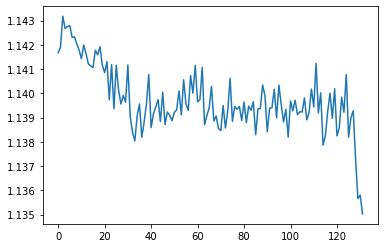

In [48]:
game = SemantleGame(w_vecs)
player = SemantleSolver(game=game, conf_thresh=0.001)
print(game.target_word)
print(player.CONF_THRESH)
won = False
while not won:
    word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
    won = player.make_guess(word)
    g = player.guesses[-1]
    print(g.word, round(g.dist, 3))
    if len(player.guesses) > 5000:
        print('stopped. ')
        print('Best guess:', player.best_guess, 'dist:', player.closest_dist)
        break

print(player.stats)
plt.plot(range(len(traj)), traj, '-')

In [ ]:
# grid search time.
def run_trial(exh, n_rand, conf_thresh, w_vecs, idx_to_word, ann_index):
    # make a game
    
    game = SemantleGame(w_vecs)
    player = SemantleSolver(game=game)
    
    player.EXH_THRESH = exh
    player.N_RANDOM = n_rand
    player.CONF_THRESH = conf_thresh
    
    won = False
    while not won:
        word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
        won = player.make_guess(word)
        if len(player.guesses) > 1000:
            break
    return len(player.guesses)

In [ ]:

n_dims = [10, 15, 20]
exh_threshes = [0.001]
n_randoms = [3]
conf_threshes = [0.2, 0.3, 0.4, 0.6, 0.8]
n_trials = 20

params_results = {}

for n_dim in n_dims:
    
    # set up space
    w_vecs = read_glove_file()
    pca = PCA(n_components=n_dim)
    mat_full = np.array([w_vecs[w] for w in w_vecs])
    mat = pca.fit_transform(mat_full)

    for i, w in enumerate(w_vecs.keys()):
        w_vecs[w] = mat[i, :]

    idx_to_word, ann_index = build_index(w_vecs)

    
    for exh in exh_threshes:
        for n_rand in n_randoms:
            for conf_thresh in conf_threshes:
                params = (n_dim, exh, n_rand, conf_thresh)
                for trial in range(n_trials):
                    n_guesses = run_trial(exh, n_rand, conf_thresh, w_vecs, idx_to_word, ann_index)
                    if not params in params_results:
                        params_results[params] = 0
                    params_results[params] += n_guesses
                params_results[params] /= n_trials
                print(params, params_results[params])

print(params_results)

In [ ]:
print(list(sorted(zip(params_results.items()), key=lambda x: x[1]))[:10])

In [ ]:
ls = list(sorted(zip(params_results.items()), key = lambda x: x[0][1]))

In [ ]:
for item in ls:
    print(item)

In [ ]:
# Now make something that plays Real Semantle
s_play = SemantleSolver()
s_play.CONF_THRESH = 0.2
s_play.add_guess('surrey', 8.11)
s_play.add_guess('injurying', -6.47)
s_play.add_guess('xxx_domain_name', 23.52)
s_play.add_guess('Program_TM_QuickAir', 4.12)
s_play.add_guess('Onlookers', 5.27)
s_play.add_guess('XXX_domain', 19.36)
s_play.add_guess('domain_suffix', 23.19)
s_play.add_guess('domain_suffixes', 16.66)
s_play.add_guess('antivirus_vendors', 14.57)
s_play.add_guess('Firefox_extensions', 26.94)
s_play.add_guess('Firefox_add_ons', 33.49)
s_play.add_guess('FireFox', 20.56)
s_play.add_guess('slashtags', 31.54)
s_play.add_guess('sitelinks', 35.35)
s_play.add_guess('backlink', 22.18)
s_play.add_guess('Macrumors', 21.93)
s_play.add_guess('keyphrases', 15.95)
s_play.add_guess('screenshot', 33.78)
s_play.add_guess('screengrab', 23.42)
s_play.add_guess('screenshots', 21.49)
s_play.add_guess('favicon', 45.82)
s_play.add_guess('menubar', 48.45)
s_play.add_guess('Downloads_folder', 41.77)
s_play.add_guess('Applications_folder', 36.37)
s_play.add_guess('scrollbar', 48.03)
s_play.add_guess('toolbar_buttons', 46.15)
s_play.add_guess('dialog_boxes', 42.41)
s_play.add_guess('filetype', 38.06)
s_play.add_guess('Passively', 25.72)
s_play.add_guess('Start_Menu', 43.70)
s_play.add_guess('shortcut_keys', 57.59)
s_play.add_guess('homescreens', 46.41)
s_play.add_guess('hotkeys', 56.43)
s_play.add_guess('hotkey', 58.91)
s_play.add_guess('keyboard_shortcut', 56.36)
s_play.add_guess('Ctrl_+', 55.19)
s_play.add_guess('CTRL_+', 52.57)
s_play.add_guess('ctrl', 48.02)
s_play.add_guess('thumbstick', 52.04)
s_play.add_guess('d_pad', 55.63)
s_play.add_guess('arrow_keys', 54.87)
s_play.add_guess('cursor', 54.05)
s_play.add_guess('spacebar', 68.31)
s_play.add_guess('stylus', 45.48)
s_play.add_guess('Fn_key', 62.21)
s_play.add_guess('shortcut_buttons', 55.77)
s_play.add_guess('Spacebar', 55.94)
s_play.add_guess('mouse_buttons', 49.41)
s_play.find_next_guess(w_vecs, ann_index, idx_to_word)
